In [1]:
import time
from datetime import datetime
import numpy as np
import tensorflow as tf
from model.vae import cnn_vae_rnn
from util.miditools import piano_roll_to_pretty_midi

import matplotlib.pyplot as plt


/home/eko/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
snapshot_interval = 200
log_interval = 50

checkpoint_file = './tfmodel/exp-new-bigru-iter-2000-0407.tfmodel'
# mudb_file = '../Nottingham/preprocessing/CN_mudb_train.npz'
# dev_file = '../Nottingham/preprocessing/CN_mudb_valid.npz' # success!!!
# dev_file = 'audio_files/preprocessing/mudb_test.npz' # success!!!
dev_file = 'audio_files/preprocessing/mudb_valid.npz' # success!!!


# train_data = np.load(mudb_file)
dev_data = np.load(dev_file)
# print range(train_data['bars'])

In [3]:
# fs = train_data['fs']
fs = dev_data['fs']
print fs

num_timesteps = int(fs)
print num_timesteps

# bars = train_data['bars']
devBars = dev_data['bars']
# np.random.shuffle(bars)

print devBars.shape
# print len(bars)

16.0
16
(8901, 256, 128)


In [4]:
note_range = int(devBars.shape[2])


# T = int(train_data['T']) #16
T = int(dev_data['T']) #16

print T

# num_batches = int(bars.shape[0])
num_batches = int(devBars.shape[0])

height = num_timesteps #19
print height

width = note_range #128
n_visible = note_range * num_timesteps
n_epochs = 100 #3

z_dim = 350
X_dim = width * height
n_hidden = z_dim
h_dim = z_dim
batch_size = 32

trainBarsBatch = np.reshape(devBars, (-1, T, height, width, 1))
trainBarsBatches = []
i = 0
while i < trainBarsBatch.shape[0] - 32:
    trainBarsBatches.append(trainBarsBatch[i:i+32])
    i += 32
devBarsBatch = np.reshape(devBars, (-1, T, height, width, 1))
devBarsBatches = []
i = 0
while i < devBarsBatch.shape[0] - 32:
    devBarsBatches.append(devBarsBatch[i:i+32])
    i += 32
#devBarsBatch = np.array_split(devBarsBatch, batch_size)
initializer = tf.contrib.layers.xavier_initializer()

audio_sr = 44100

devLoss = True
devInterval = 100

16
16


In [5]:
##################################################################
# Loading the model
##################################################################
with tf.name_scope('placeholders'):
    z = tf.placeholder(tf.float32, shape=[None, z_dim], name="Generated_noise") #z_dim=350
    #(batch x T x width x height x channels)
    z_rnn_samples = tf.placeholder(tf.float32, shape=[None, T, height, width, 1], name="Generated_midi_input")
    
    X = tf.placeholder(tf.float32, shape=[None, T, height, width, 1], name="Training_samples")
    kl_annealing = tf.placeholder(tf.float32, name="KL_annealing_multiplier")

    
# model selection
model = cnn_vae_rnn(X, z, z_rnn_samples, X_dim, z_dim=z_dim, h_dim=h_dim, initializer=initializer, keep_prob=1.0)

X_samples, out_samples, logits = (model['X_samples'], model['out_samples'], model['logits'])
z_mu, z_logvar = (model['z_mu'], model['z_logvar'])

In [6]:
##################################################################
# Losses
##################################################################
with tf.name_scope("Loss"):
    X_labels = tf.reshape(X, [-1, width*height])

    with tf.name_scope("cross_entropy"):
#         recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X_labels), 1) #recon_loss
#         print X_labels
        recon_loss = tf.reduce_sum(tf.nn.softmax(logits=logits), 1)
    
    with tf.name_scope("kl_divergence"):
        kl_loss = kl_annealing * 0.5 * tf.reduce_sum(tf.square(z_mu) + tf.exp(z_logvar) - z_logvar - 1.,1) #kl_loss
    
    recon_loss = tf.reduce_mean(tf.reshape(recon_loss, [-1, T]), axis=1)

    loss = tf.reduce_mean(recon_loss + kl_loss)

## recon_loss, loss graph visualization

In [7]:
##################################################################
# Optimizer
##################################################################
with tf.name_scope("Optimizer"):
    solver = tf.train.AdamOptimizer()
    grads = solver.compute_gradients(loss)
    grads = [(tf.clip_by_norm(g, clip_norm=1), v) for g, v in grads]
    train_op = solver.apply_gradients(grads)

##################################################################
# Logging
##################################################################
with tf.name_scope("Logging"):
    recon_loss_ph = tf.placeholder(tf.float32)
    kl_loss_ph = tf.placeholder(tf.float32)
    loss_ph = tf.placeholder(tf.float32)
    audio_ph = tf.placeholder(tf.float32)

    tf.summary.scalar("Reconstruction_loss", recon_loss_ph)
    tf.summary.scalar("KL_loss", kl_loss_ph)
    tf.summary.scalar("Loss", loss_ph)
    tf.summary.audio("sample_output", audio_ph, audio_sr)
    log_op = tf.summary.merge_all()

writer = tf.summary.FileWriter('./tb/', graph=tf.get_default_graph())

sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))
#sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))

# Run Initialization operations
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()

loss_avg = 0.0
decay = 0.99
min_loss = 100.0
min_dev_loss = 200.0
time0 = time.time()

### add t-sne clustering mean visualization
### add deconvolutional layer visualization
### 

========== EPOCH 0 ==========
***recon_loss = 1.000000***
	iter = 0, local_loss (cur) = 223.936737, local_loss (avg) = 2.239367, kl = 222.936737
Tensor("vae_rnn/Encoder_train/Calculate_mu_sigma/add:0", shape=(?, 350), dtype=float32)

	Total time elapsed: 5.562024 sec. Average time per batch: 5.562024 sec

***recon_loss = 1.000000***
	iter = 50, local_loss (cur) = 2.050280, local_loss (avg) = 2.237476, kl = 1.050279
Tensor("vae_rnn/Encoder_train/Calculate_mu_sigma/add:0", shape=(?, 350), dtype=float32)

	Total time elapsed: 194.195938 sec. Average time per batch: 3.807763 sec

***recon_loss = 1.000000***
	iter = 100, local_loss (cur) = 1.361655, local_loss (avg) = 2.228718, kl = 0.361656
Tensor("vae_rnn/Encoder_train/Calculate_mu_sigma/add:0", shape=(?, 350), dtype=float32)

	Total time elapsed: 382.865200 sec. Average time per batch: 3.790745 sec

Saving checkpoint with train loss 1
***recon_loss = 1.000000***
	iter = 150, local_loss (cur) = 1.494166, local_loss (avg) = 2.221373, kl = 

/home/eko/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


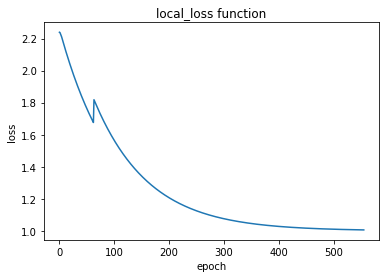

In [8]:
##################################################################
# Optimization loop
##################################################################
i = 0
loss_visual_list = []

for e in range(n_epochs):
    print("%s EPOCH %d %s" % ("".join(10*["="]), e, "".join(10*["="])))
    for batch in trainBarsBatches:
        kl_an = 1.0#min(1.0, (i / 10) / 200.)
        _,loss_out, kl, recon = sess.run([train_op, loss, kl_loss, recon_loss], feed_dict={X: batch, kl_annealing: kl_an})

        if (i % log_interval) == 0:
            loss_avg = decay*loss_avg + (1-decay)*loss_out
            print('***recon_loss = %f***' % np.mean(recon))
#             print(accuracy) 
            
            print('\titer = %d, local_loss (cur) = %f, local_loss (avg) = %f, kl = %f'
                % (i, loss_out, loss_avg, np.mean(kl)))
            
            print (z_mu)
            
            time_spent = time.time() - time0
            print('\n\tTotal time elapsed: %f sec. Average time per batch: %f sec\n' %
                (time_spent, time_spent / (i+1)))
            
            loss_visual_list.append(loss_avg)
            
            #Random samples
            z_in = np.random.randn(1, z_dim)
            z_rnn_out = np.zeros((T,height,width,1))
            first = True
            for j in range(T):
                z_rnn_out = np.expand_dims(z_rnn_out, axis=0)
                samples = sess.run(X_samples, feed_dict={z: np.random.randn(1, z_dim), X: z_rnn_out})
                frames = j + 1
                samples = samples.reshape((-1, height, width, 1))
                z_rnn_out = np.concatenate([samples[:frames], np.zeros((T-frames, height, width, 1))])
            samples = samples.reshape((num_timesteps*(T), note_range))
            thresh_S = samples >= 0.5
            
            pm_out = piano_roll_to_pretty_midi(thresh_S.T * 127, fs=fs)
            
            midi_out1 = 'out/{}.mid'.format(datetime.now().strftime("%Y.%m.%d.%H:%M:%S"))
            pm_out.write(midi_out1)
            
            midi_out = './tb/audio/test002_{0}.mid'.format(datetime.now().strftime("%Y.%m.%d.%H:%M:%S"))
            wav_out = './tb/audio/test002_{0}.wav'.format(datetime.now().strftime("%Y.%m.%d.%H:%M:%S"))
            audio = pm_out.synthesize() 
            audio = audio.reshape((1, len(audio)))
            #Write out logs
            summary = sess.run(log_op, feed_dict={recon_loss_ph: np.mean(recon), kl_loss_ph: np.mean(kl),
                                                 loss_ph: loss_out, audio_ph: audio})
            writer.add_summary(summary, i)
                
            
#             plt.show()
            
#             plt.plot(np.mean(recon))
#             plt.title('recon_loss function')
#             plt.ylabel('loss')
#             plt.xlabel('epoch')
            
#         plt.legend(['train', 'test'], loc='upper left')
        
        if devLoss and i % devInterval == 0:
            #dls = []
            #for dbatch in devBarsBatches:
            #    dev_loss_out, kl, recon = sess.run([loss, kl_loss, recon_loss], feed_dict={X: dbatch, kl_annealing: kl_an})
            #    dls.append(dev_loss_out)
            #dev_loss_out = sum(dls) / len(dls)
            #print("Dev set loss %.2f" % dev_loss_out)

            if loss_out < min_dev_loss:
                print("Saving checkpoint with train loss %d" % loss_out)
                min_dev_loss = loss_out
                

                
        i += 1
        saver.save(sess, checkpoint_file)
        
plt.plot(loss_visual_list) 
plt.xlabel('epoch')
plt.ylabel('loss') 
plt.title('local_loss function')
plt.legend() 
plt.show()


In [ ]:
##################################################################
# Optimization loop
##################################################################
# i = 0
# losses = []
# for batch in testBarsBatches:
#     kl_an = 1.0#min(1.0, ((e+1)*num_batches) / (2*num_batches))
#     loss_out, kl, recon = sess.run([loss, kl_loss, recon_loss], feed_dict={X: batch, kl_annealing: kl_an})
#     losses.append(loss_out)
# print(sum(losses) / len(losses))


# bidirectional_generation

#Random samples
z_in = np.random.randn(1, z_dim)
#z_in = np.random.normal(loc=0.0, scale=1.0, size=(1, z_dim))
z_rnn_out = np.zeros((T,height,width,1))
first = True

for j in range(T):
    z_rnn_out = np.expand_dims(z_rnn_out, axis=0)
    samples = sess.run(X_samples, feed_dict={z: z_in, X: z_rnn_out})
    frames = j + 1
    
    if first:
        frames = 2
    z_rnn_out = samples.reshape((T, height, width, 1))
    
    if first:
        samples = samples.reshape((-1, height, width, 1))
        z_rnn_out = np.concatenate([samples[:frames], np.zeros((T-frames, height, width, 1))])
        first = False

samples = z_rnn_out.reshape((num_timesteps*T, note_range))
thresh_S = samples >= 0.5


# #Random samples
# z_in = np.random.randn(1, z_dim)
# z_rnn_out = np.zeros((1,height,width,1))
# first = True
# for j in range(T*3):
#     z_rnn_out = np.expand_dims(z_rnn_out, axis=0)
#     samples = sess.run(X_samples, feed_dict={z: z_in, X: z_rnn_out})
    
#     if first:
#         frames = 2
#     z_rnn_out = samples.reshape((frames, height, width, 1))
#     if first:
#         z_rnn_out = np.expand_dims(z_rnn_out[-1,:,:,:], axis=0)
#         first = False
            
# samples = samples.reshape((num_timesteps*T*3, note_range))


# thresh_S = (samples >= 0.5).astype(np.float32) * 127

pm_out = piano_roll_to_pretty_midi(thresh_S.T * 127, fs=fs)
midi_out = 'out/{}.mid'.format(datetime.now().strftime("%Y.%m.%d.%H:%M:%S"))
pm_out.write(midi_out)